# Real case - DNN applied to Gesture classification
- Using Edge Impulse Studio 
- MJRovai @ 15Jun21

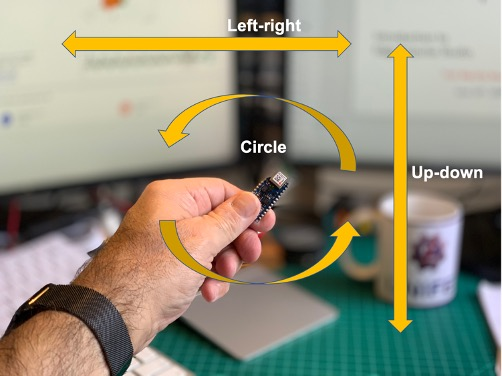

Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import sys, os, random
import numpy as np
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [3]:
# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

In [5]:
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    if res == 'loss':
        plt.legend(['Training', res], loc='upper right')
    else:
        plt.legend(['Training', res], loc='lower right')
    plt.show() 

## Import Dataset

The data used here were import from Edge Impulse Studio. The dataset were collected using Smart phone. The raw  data imported were already preprocessed (Feature Extracted).

In [6]:
API_KEY = 'ei_06b0e85ff53b3823dd57110ddb56323a0b245989c0d173d85ff867ba6774f8e2'

X = download_data('https://studio.edgeimpulse.com/v1/api/35908/training/7/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/35908/training/7/y')

Store the data in a temporary file, and load it back through Numpy.

In [7]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

X.shape, Y.shape

((3200, 33), (3200,))

In [8]:
X[0]

array([3.6130735e-01, 2.4801588e+00, 2.5907406e-01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.3257746e-04,
       2.2279157e-03, 5.1109153e-03, 2.2747493e-03, 2.3545037e-01,
       2.4801588e+00, 1.6814463e-01, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 4.0619800e-04, 9.5658604e-04,
       2.2669150e-03, 9.0918847e-04, 2.7433084e-03, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.9106139e-07, 3.8327943e-08, 3.9582227e-07,
       8.6537007e-08], dtype=float32)

In [9]:
Y

array([2, 2, 2, ..., 3, 3, 3], dtype=int32)

In [10]:
set(Y)

{1, 2, 3, 4}

## Define our labels and split the data up in a test and training set:

In [11]:
classes_values = [ "circle", "idle", "left_right", "up_down" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

In [12]:
Y.shape

(3200, 4)

In [13]:
Y[0]

array([0., 1., 0., 0.], dtype=float32)

In [14]:
Y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1)

In [16]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2560, 33) (2560, 4)
(640, 33) (640, 4)


## Create Model

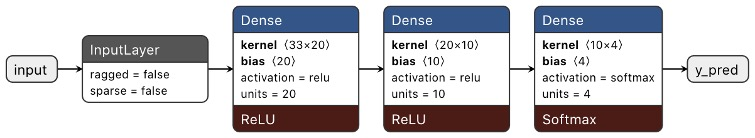

In [17]:
input_length = X_train[0].shape[0]
input_length

33

In [18]:
# model architecture
model = Sequential()
model.add(
    InputLayer([input_length]))
model.add(
    Dense(20,
          activation='relu',
          activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(
    Dense(10,
          activation='relu',
          activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                680       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
y_pred (Dense)               (None, 4)                 44        
Total params: 934
Trainable params: 934
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Train the model:

`tf.data.Dataset.from_tensor_slice`:

Creates a `Dataset` whose elements are slices of the given tensors.

The given tensors are sliced along their first dimension. This operation
preserves the structure of the input tensors, removing the first dimension
of each tensor and using it as the dataset dimension. All input tensors
must have the same size in their first dimensions.

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [21]:
print(train_dataset)
print(validation_dataset)

<TensorSliceDataset shapes: ((33,), (4,)), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((33,), (4,)), types: (tf.float32, tf.float32)>


In [22]:
BATCH_SIZE = 32
EPOCHS = 30
callbacks = []

In [23]:
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [24]:
# train the neural network
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/30
80/80 - 1s - loss: 1.9162 - accuracy: 0.1684 - val_loss: 1.2466 - val_accuracy: 0.4094
Epoch 2/30
80/80 - 0s - loss: 1.0945 - accuracy: 0.4359 - val_loss: 0.9812 - val_accuracy: 0.5156
Epoch 3/30
80/80 - 0s - loss: 0.8615 - accuracy: 0.6227 - val_loss: 0.7608 - val_accuracy: 0.7031
Epoch 4/30
80/80 - 0s - loss: 0.6444 - accuracy: 0.7164 - val_loss: 0.5720 - val_accuracy: 0.7250
Epoch 5/30
80/80 - 0s - loss: 0.4806 - accuracy: 0.9223 - val_loss: 0.4371 - val_accuracy: 0.9781
Epoch 6/30
80/80 - 0s - loss: 0.3539 - accuracy: 0.9871 - val_loss: 0.3102 - val_accuracy: 0.9828
Epoch 7/30
80/80 - 0s - loss: 0.2378 - accuracy: 0.9895 - val_loss: 0.1978 - val_accuracy: 0.9875
Epoch 8/30
80/80 - 0s - loss: 0.1457 - accuracy: 0.9910 - val_loss: 0.1248 - val_accuracy: 0.9875
Epoch 9/30
80/80 - 0s - loss: 0.0925 - accuracy: 0.9918 - val_loss: 0.0856 - val_accuracy: 0.9875
Epoch 10/30
80/80 - 0s - loss: 0.0640 - accuracy: 0.9918 - val_loss: 0.0644 - val_accuracy: 0.9891
Epoch 11/30
80/80 -

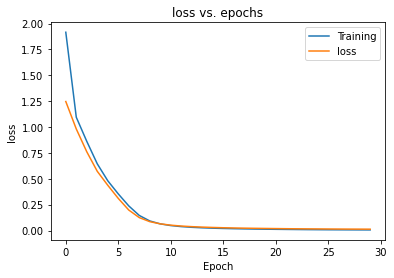

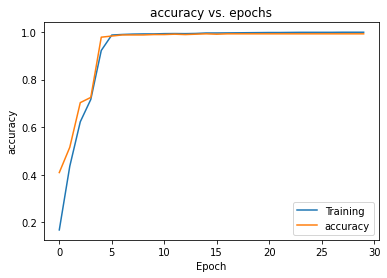

accuracy: 0.992


In [25]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')
get_test_accuracy(model, X_test, Y_test)

In [26]:
Y_pred = np.argmax(model.predict(X_test), axis=-1)

In [27]:
Y_pred

array([1, 2, 2, 3, 1, 1, 1, 2, 1, 0, 1, 2, 3, 2, 3, 1, 3, 2, 0, 2, 2, 0,
       2, 1, 1, 1, 0, 0, 3, 0, 0, 1, 2, 1, 1, 3, 1, 2, 1, 2, 2, 0, 0, 3,
       0, 0, 2, 3, 2, 3, 1, 1, 1, 2, 2, 1, 3, 3, 2, 0, 2, 0, 2, 2, 1, 3,
       3, 1, 0, 1, 2, 1, 0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 2, 3, 1, 1, 0, 1,
       3, 1, 1, 2, 2, 3, 3, 1, 1, 1, 3, 2, 2, 2, 0, 1, 1, 3, 3, 1, 3, 0,
       1, 3, 0, 3, 1, 2, 0, 2, 1, 1, 0, 2, 3, 2, 2, 0, 1, 1, 3, 0, 0, 3,
       2, 3, 3, 2, 1, 0, 1, 1, 2, 1, 3, 3, 2, 3, 0, 3, 1, 2, 2, 1, 1, 0,
       3, 0, 2, 3, 0, 0, 1, 1, 1, 1, 2, 2, 3, 2, 3, 0, 3, 1, 3, 0, 0, 0,
       0, 0, 3, 1, 0, 2, 0, 1, 2, 1, 3, 3, 3, 3, 1, 0, 1, 1, 3, 2, 0, 0,
       3, 2, 1, 3, 1, 0, 2, 2, 1, 2, 3, 0, 1, 3, 0, 3, 2, 3, 2, 0, 1, 3,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 3, 2, 3, 2, 3, 2, 1, 2, 1, 3, 3, 3, 1,
       3, 2, 1, 1, 2, 3, 3, 0, 0, 1, 1, 1, 2, 1, 0, 0, 2, 3, 1, 0, 3, 1,
       0, 1, 2, 1, 1, 3, 0, 0, 3, 2, 0, 3, 3, 1, 2, 1, 2, 2, 2, 2, 1, 1,
       2, 0, 0, 0, 3, 1, 2, 1, 3, 3, 0, 2, 2, 1, 0,

In [28]:
YY_test = np.argmax(Y_test, axis=-1)
YY_test

array([1, 2, 2, 3, 1, 1, 1, 2, 1, 0, 1, 2, 3, 2, 3, 1, 3, 2, 0, 2, 2, 0,
       2, 1, 1, 1, 0, 0, 3, 0, 0, 1, 2, 1, 1, 3, 1, 2, 1, 2, 2, 0, 0, 3,
       0, 0, 2, 3, 2, 3, 1, 1, 1, 2, 2, 1, 3, 3, 2, 0, 2, 0, 2, 2, 1, 3,
       3, 1, 0, 2, 2, 1, 0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 2, 3, 1, 1, 0, 1,
       3, 1, 1, 2, 2, 3, 3, 1, 1, 1, 3, 2, 2, 2, 0, 1, 1, 3, 3, 1, 3, 0,
       1, 3, 0, 3, 1, 2, 0, 2, 1, 1, 0, 2, 3, 2, 2, 0, 1, 1, 3, 0, 0, 3,
       2, 3, 3, 2, 1, 0, 1, 1, 2, 1, 3, 3, 2, 3, 0, 3, 1, 2, 2, 1, 1, 0,
       3, 0, 1, 3, 0, 0, 1, 1, 1, 1, 2, 2, 3, 2, 3, 0, 3, 1, 3, 0, 0, 0,
       0, 0, 3, 1, 0, 1, 0, 1, 2, 1, 3, 3, 3, 3, 1, 0, 1, 1, 3, 2, 0, 0,
       3, 2, 1, 3, 1, 0, 2, 2, 1, 2, 3, 0, 1, 3, 0, 3, 2, 3, 2, 0, 1, 3,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 3, 2, 3, 2, 3, 2, 1, 2, 1, 3, 3, 3, 1,
       3, 2, 1, 1, 2, 3, 3, 0, 0, 1, 1, 1, 2, 1, 0, 0, 2, 3, 1, 0, 3, 1,
       0, 1, 2, 1, 1, 3, 0, 0, 3, 2, 0, 3, 3, 1, 2, 1, 2, 2, 2, 2, 1, 1,
       2, 0, 0, 0, 3, 1, 2, 1, 3, 3, 0, 2, 2, 1, 0,

In [29]:
print(classification_report(YY_test, Y_pred, target_names=classes_values))

              precision    recall  f1-score   support

      circle       0.99      1.00      0.99       155
        idle       0.99      0.99      0.99       185
  left_right       0.99      0.99      0.99       145
     up_down       1.00      0.99      0.99       155

    accuracy                           0.99       640
   macro avg       0.99      0.99      0.99       640
weighted avg       0.99      0.99      0.99       640



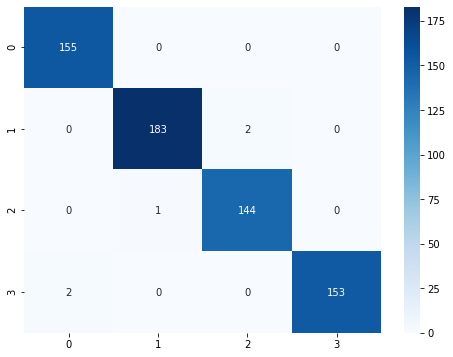

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(YY_test, Y_pred), cmap='Blues', annot=True, fmt='g');

In [31]:
# Save the model to disk to be further converted to TF Lite
model.save('gesture_class_model')

INFO:tensorflow:Assets written to: gesture_class_model/assets


In [32]:
# Save the model as .h5 to be visualized
model.save('gesture_class_model.h5')